# Unit 3 Capstone: Predicting Churn in Telco Customers

Churn, or customer attrition, is the loss of customers.

Churn is an area of interest for many industries, since it is often more expensive to bring in a new customer than to retain one. Using the [Telco Customer Churn](https://www.kaggle.com/blastchar/telco-customer-churn) dataset from Kaggle, I hope to explore the data and determine which features might cause a customer to leave, and if a combination of features might make a customer "high risk" for leaving the company. 

This dataset is a binary classifier, and I will create a model with a target variable of 'churn'.


In [57]:
import pandas as pd
import numpy as np
current_state = np.random.get_state()
np.random.set_state(current_state)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy import stats
from scipy.stats import ttest_ind
import time 
import random

from collections import Counter
from sklearn import ensemble
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn import svm
from sklearn import metrics
from IPython.display import display
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Load the data

data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [4]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### 1. Initial Data Analysis

In [5]:
# Check the shape

data.shape

(7043, 21)

In [6]:
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [7]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [8]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Initial exploration tells us the following: our dataset has 7043 rows and 21 columns. Of the columns, 3 are numerical fields (SeniorCitizen, tenure, and monthly charges). The other columns are categorical variables.

The senior citizen column is a binary classifier with two possible inputs: 0 for 'not a senior citizen' and 1 for 'a senior citizen'

Of the original features, 'customer ID' does not do much for us, so we delete it.

In [9]:
# drop customer ID

data = data.drop('customerID',axis=1)

In [10]:
# Value counts for our target category
data['Churn'].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

### Checking for missing data and possible imputing

Text(0.5, 1.0, 'Heat Map of Missing Values')

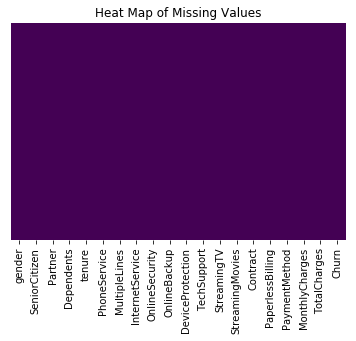

In [11]:
# Make a heatmap of missing data values

sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis').set_title('Heat Map of Missing Values')

In [12]:
# Double check
data.isnull().values.any()

False

Despite being told there are no null values, later on I found that there are several blank entires. All of them are in the 'TotalCharges' column and I assume they have to do with someone who never paid the company anything. As such, we'll be dropping them from the dataset. We could also impute the data with '0' in the appropriate field. Since we are trying here to focus on predicting customer churn, we will consider customers who never paid as not really customers, and ignore their behavior.

In [13]:
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0).astype('float32')

In [14]:
data = data[data.TotalCharges != 0]

We have no missing values in the entire dataset, which is great.

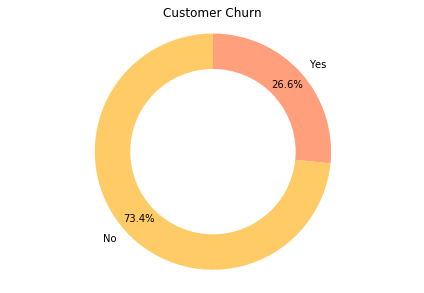

In [15]:
churn = data['Churn'].value_counts()
c_scheme = ['#FFCB66', '#FF9F7C', '#FF809C', '#D872B7', '#9070C2', '#467BD3', '#0084D3', '#0089C0', '#00866B']


# pie chart of workers
labels = ['No', 'Yes']
sizes = churn
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')
plt.tight_layout()
plt.title('Customer Churn')
plt.show()

In [16]:
# UP = india_census.loc[lambda df: india_census['State'] == "Uttar Pradesh", :]

# Partners 

Partner = data.loc[lambda data: data['Partner'] == 'Yes', :]
partner_churn = Partner['Churn'].value_counts()

no_partner = data.loc[lambda data: data['Partner'] == 'No', :]
no_part_churn = no_partner['Churn'].value_counts()

# Payment Methods

elec_check = data.loc[lambda data: data['PaymentMethod'] == 'Electronic check', :]
mailed_check = data.loc[lambda data: data['PaymentMethod'] == 'Mailed check', :]
bank_trans = data.loc[lambda data: data['PaymentMethod'] == 'Bank transfer (automatic)', :]
credit = data.loc[lambda data: data['PaymentMethod'] == 'Credit card (automatic)', :]


In [17]:
data['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1604
Bank transfer (automatic)    1542
Credit card (automatic)      1521
Name: PaymentMethod, dtype: int64

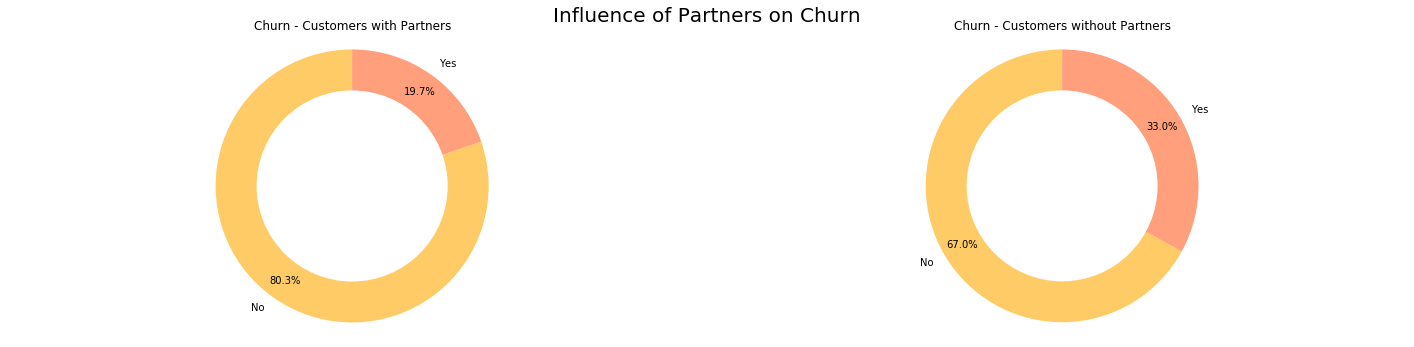

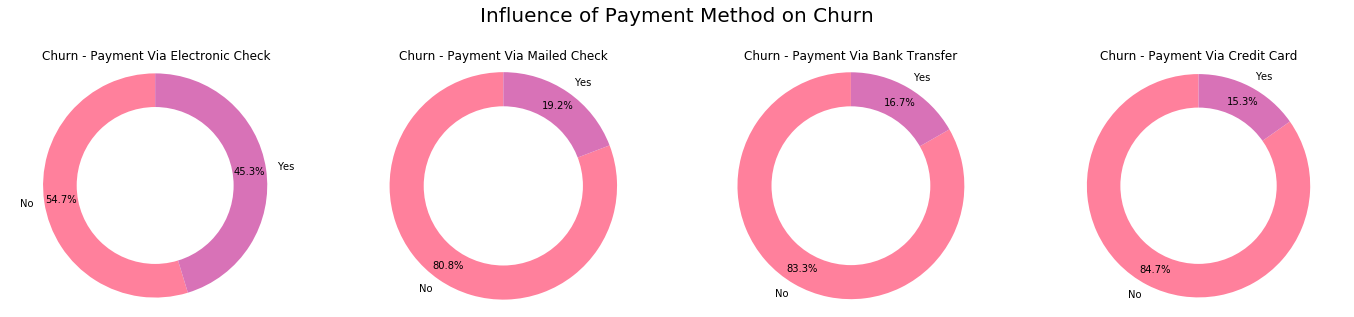

In [18]:
# Plot 1: Partner vs. No Partner

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
labels = ['No', 'Yes']
sizes = partner_churn
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.title('Churn - Customers with Partners')

plt.subplot(1, 2, 2)
labels = ['No', 'Yes']
sizes = no_part_churn
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout(pad=2)
plt.title('Churn - Customers without Partners')
plt.suptitle('Influence of Partners on Churn', fontsize=20)
plt.show()


# Plot 2: 

plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
labels = ['No', 'Yes']
sizes = elec_check['Churn'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme[2:])

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.title('Churn - Payment Via Electronic Check')

plt.subplot(1, 4, 2)
labels = ['No', 'Yes']
sizes = mailed_check['Churn'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme[2:])

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout()
plt.title('Churn - Payment Via Mailed Check')

plt.subplot(1, 4, 3)
labels = ['No', 'Yes']
sizes = bank_trans['Churn'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme[2:])

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout(pad=5)
plt.title('Churn - Payment Via Bank Transfer')

plt.subplot(1, 4, 4)
labels = ['No', 'Yes']
sizes = credit['Churn'].value_counts()
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, shadow=False, colors=c_scheme[2:])

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.tight_layout(pad=5)
plt.title('Churn - Payment Via Credit Card')

plt.suptitle('Influence of Payment Method on Churn', fontsize=20)
plt.show()

# Plot 3 



In [19]:
#'gender', 'SeniorCitizen', 'Partner', 'Dependents',
#       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
#       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
#       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
#       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'


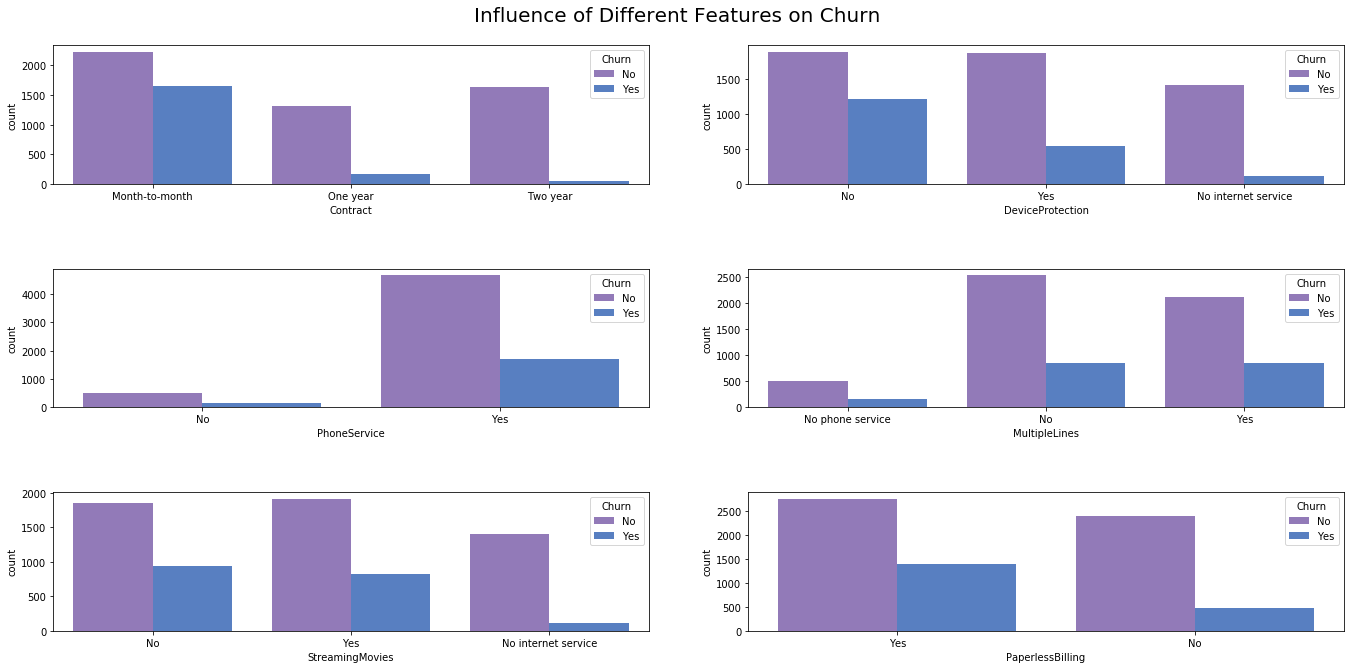

In [20]:
contract = data['Contract'].value_counts()
labels=['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card']

plt.figure(figsize=(20, 10))

plt.subplot(3, 2, 1)
sns.countplot(x='Contract', hue='Churn', data=data, palette=c_scheme[4:]) 

plt.subplot(3, 2, 2)
sns.countplot(x=data['DeviceProtection'], hue=data['Churn'], data=data, palette=c_scheme[4:]) 


plt.subplot(3, 2, 3)
sns.countplot(x=data['PhoneService'], hue=data['Churn'], data=data, palette=c_scheme[4:]) 

plt.subplot(3, 2, 4)
sns.countplot(x=data['MultipleLines'], hue=data['Churn'], data=data, palette=c_scheme[4:]) 

plt.subplot(3, 2, 5)
sns.countplot(x=data['StreamingMovies'], hue=data['Churn'], data=data, palette=c_scheme[4:]) 

plt.subplot(3, 2, 6)
sns.countplot(x=data['PaperlessBilling'], hue=data['Churn'], data=data, palette=c_scheme[4:]) 


plt.suptitle('Influence of Different Features on Churn', fontsize=20)
plt.tight_layout(pad=5)



From this initial exploration, we have areas of interest in customers with month-to-month contracts, customers who don't use device protection, customers who don't stream movies, and customers who use paperless billing. Of course we want to consider percentage of the whole. Take the "phone service" category, customers with phone service are more likely to leave the service at first glance, but there are also far more customers who have phone service than not. 

# Exploring the numerical data

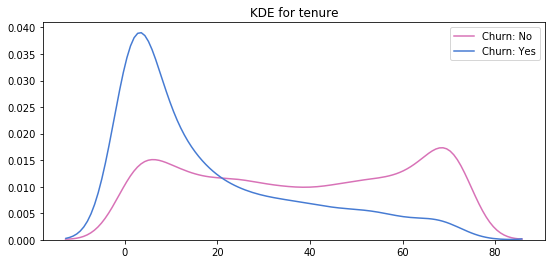

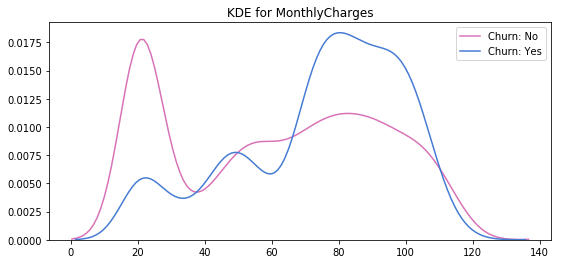

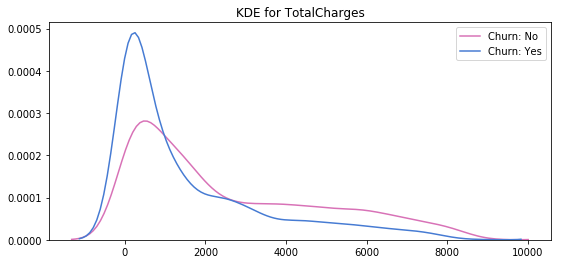

In [21]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(data[data['Churn'] == 'No'][feature].dropna(), color='#D872B7', label= 'Churn: No')
    ax1 = sns.kdeplot(data[data['Churn'] == 'Yes'][feature].dropna(), color='#467BD3', label= 'Churn: Yes')
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

Analysis of these graphs tells us the following: 

* New customers are among the most likely to churn
* Customers with higher monthly charges are more likely to churn 
* Tenure and monthly charges are likely significant features to look at
* Total charges may be less significant due to an effect already observed from tenure and monthly charges


Note: kde (kernel density estimation) is just a way to estimate the probability density, so the area under the plot curve is always 1 (y-axis is the probability). For the tenure we can see that clients that churn have a higher probability of being less than 20 months in the tele company.

In [22]:
# I want to look at scatterplots of tenure, monthly charges, and total charges, but senior citizen is also currently
# int type

data['SeniorCitizen'] = pd.Categorical(data['SeniorCitizen']) #Changing from int to categorical
data.dtypes

gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges         float32
Churn                 object
dtype: object

In [23]:
numerics = ['float64', 'int64', 'float32']
numeric_df = data.select_dtypes(include=numerics)

In [24]:
numeric_df = pd.concat([numeric_df, data["Churn"]], axis=1)

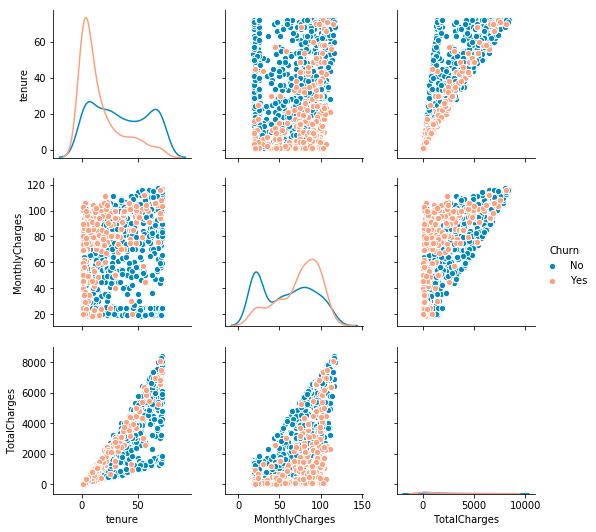

In [25]:

g = sns.PairGrid(numeric_df.sample(n=1000), hue="Churn", palette=['#0089C0','#FF9F7C'])
g = g.map_offdiag(plt.scatter, linewidths=1, edgecolor="w", s=40)
g = g.map_diag(sns.kdeplot)
g = g.add_legend()

We can see a bit of delineation between customers who churn and those who don't in the scatterplot matrix

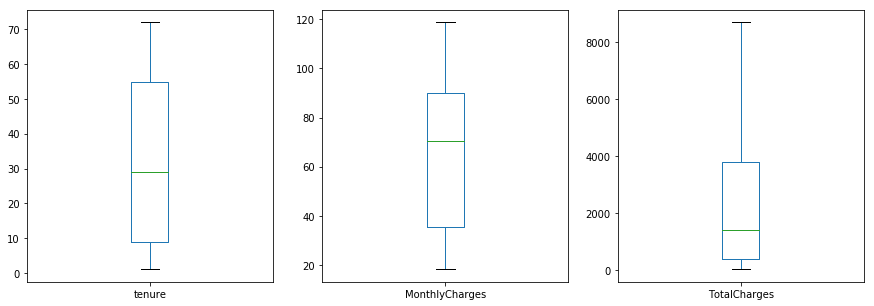

In [26]:
numeric_df.plot(kind='box', subplots=True, figsize=(15,5))
plt.plot()
plt.show()

In [27]:
data['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

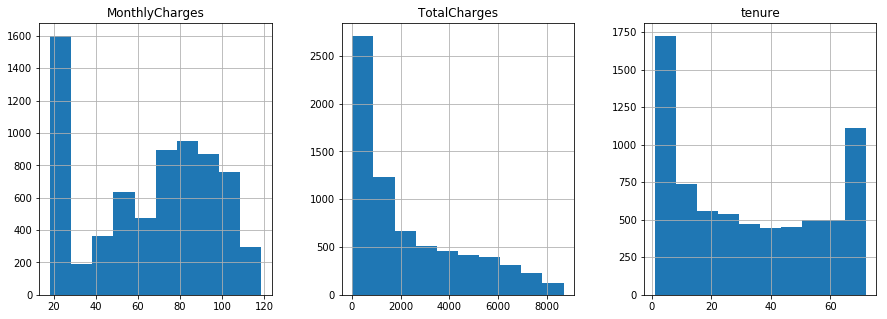

In [28]:
numeric_df.hist(layout=(1,3), figsize=(15,5))
plt.plot()
plt.show()

While we looked at how the features related to each other and how they related to the feature we're trying to predict, we can see from these plots that the numerical features are not normally distributed. 

# Deeper Exploration of Categorical Variables

In [29]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

We have 16 categorical variables:

* Four variables deal with the person and their home life (gender, SeniorCitizen, Partner, Dependents)
* Five variables are subscription types or add-ons (PhoneService, MultipleLines, InternetService, StreamingTV, StreamingMovies)
* Three variables deal with billing (Contract, PaperlessBilling, PaymentMethod)
* The remaining four variables have to do with security and support (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport)

Exploring them at more of a face value, we find the following:

* Six binary features
* Nine features with three unique values
* One feature with four unique values 

### Senior Citizen Status 

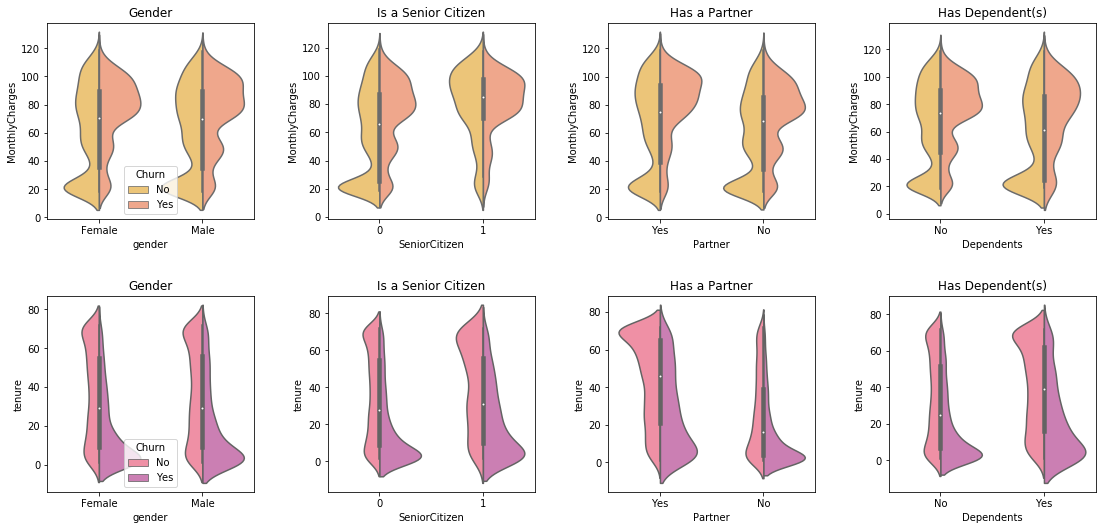

In [30]:
fig, axis = plt.subplots(2, 4, figsize=(16,8))
axis[0][0].set_title("Gender")
axis[0][1].set_title("Is a Senior Citizen")
axis[0][2].set_title("Has a Partner")
axis[0][3].set_title("Has Dependent(s)")
axis[1][0].set_title("Gender")
axis[1][1].set_title("Is a Senior Citizen")
axis[1][2].set_title("Has a Partner")
axis[1][3].set_title("Has Dependent(s)")

ax = sns.violinplot(x="gender", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][0])

ax = sns.violinplot(x="SeniorCitizen", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][1])
ax.legend_.remove()

ax = sns.violinplot(x="Partner", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][2])
ax.legend_.remove()

ax = sns.violinplot(x="Dependents", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][3])
ax.legend_.remove()

# tenure

ax = sns.violinplot(x="gender", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][0])

ax = sns.violinplot(x="SeniorCitizen", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][1])
ax.legend_.remove()

ax = sns.violinplot(x="Partner", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][2])
ax.legend_.remove()

ax = sns.violinplot(x="Dependents", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][3])
ax.legend_.remove()

plt.tight_layout(pad=3)

Gender does not seem to play a role in churn. Senior citizens with high monthly costs are associated with higher churn. Not having a partner seems to also slightly impact churn when related to monthly costs.

In [31]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

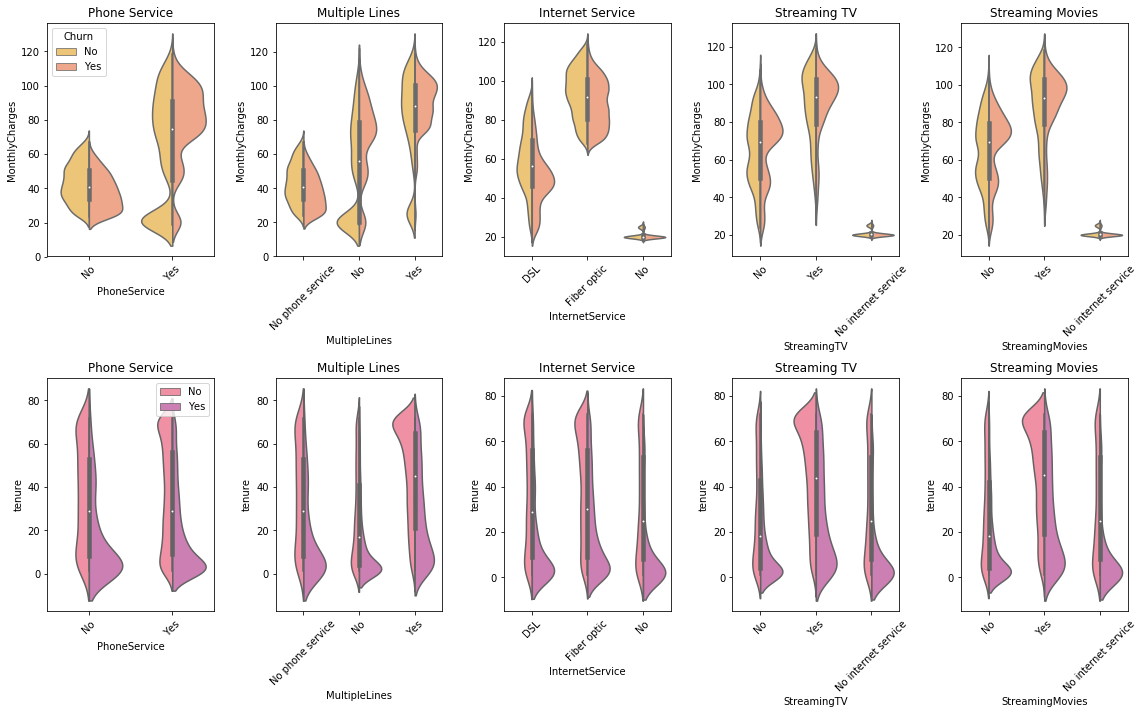

In [32]:
fig, axis = plt.subplots(2, 5, figsize=(16,10))
axis[0][0].set_title("Phone Service")
axis[0][1].set_title("Multiple Lines")
axis[0][2].set_title("Internet Service")
axis[0][3].set_title("Streaming TV")
axis[0][4].set_title("Streaming Movies")
axis[1][0].set_title("Phone Service")
axis[1][1].set_title("Multiple Lines")
axis[1][2].set_title("Internet Service")
axis[1][3].set_title("Streaming TV")
axis[1][4].set_title("Streaming Movies")

# Monthly Cost

ax = sns.violinplot(x="PhoneService", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][0])
plt.setp(ax.get_xticklabels(), rotation=45)

ax = sns.violinplot(x="MultipleLines", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="InternetService", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="StreamingTV", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][3])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="StreamingMovies", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][4])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

# tenure

ax = sns.violinplot(x="PhoneService", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][0])
plt.setp(ax.get_xticklabels(), rotation=45)
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ["No", "Yes"])

ax = sns.violinplot(x="MultipleLines", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="InternetService", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="StreamingTV", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][3])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="StreamingMovies", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][4])
ax.legend_.remove()

plt.setp(ax.get_xticklabels(), rotation=45)


plt.tight_layout(pad=1)

Again we can see that customers less than 20 months are at higher risk for churn, regardless of other status as senior citizen, parent, gender, or partner status. 

Customers with multiple phone lines are at slightly higher risk for churn

Streaming service is not predictive of churn

### Billing 

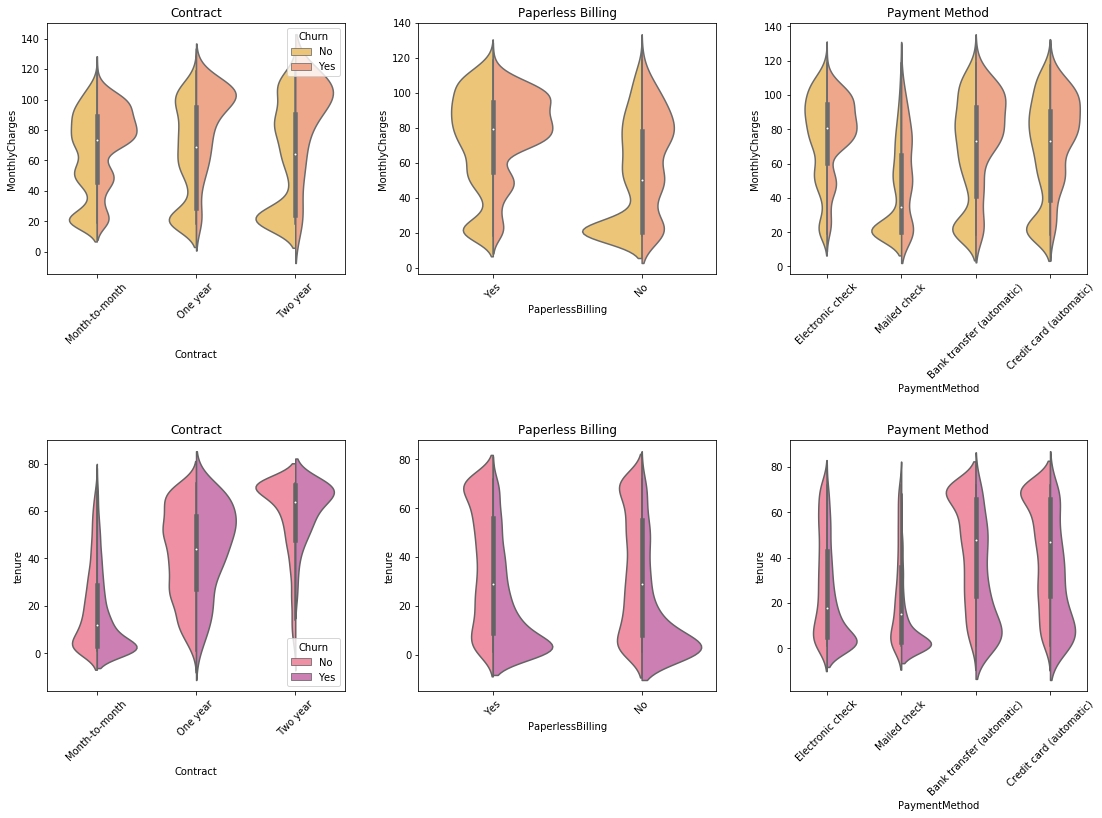

In [33]:
# Contract, PaperlessBilling, PaymentMethod

fig, axis = plt.subplots(2, 3, figsize=(16,12))
axis[0][0].set_title("Contract")
axis[0][1].set_title("Paperless Billing")
axis[0][2].set_title("Payment Method")
axis[1][0].set_title("Contract")
axis[1][1].set_title("Paperless Billing")
axis[1][2].set_title("Payment Method")

ax = sns.violinplot(x="Contract", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][0])
plt.setp(ax.get_xticklabels(), rotation=45)


ax = sns.violinplot(x="PaperlessBilling", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()


ax = sns.violinplot(x="PaymentMethod", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

# tenure

ax = sns.violinplot(x="Contract", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][0])
plt.setp(ax.get_xticklabels(), rotation=45)



ax = sns.violinplot(x="PaperlessBilling", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()


ax = sns.violinplot(x="PaymentMethod", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()



plt.tight_layout(pad=3)

High monthly charges influence churn. Month-to-month contracting is associated with earlier churn, whereas 2-year contracts average at around 70 month tenure. 

### Security and Tech Support


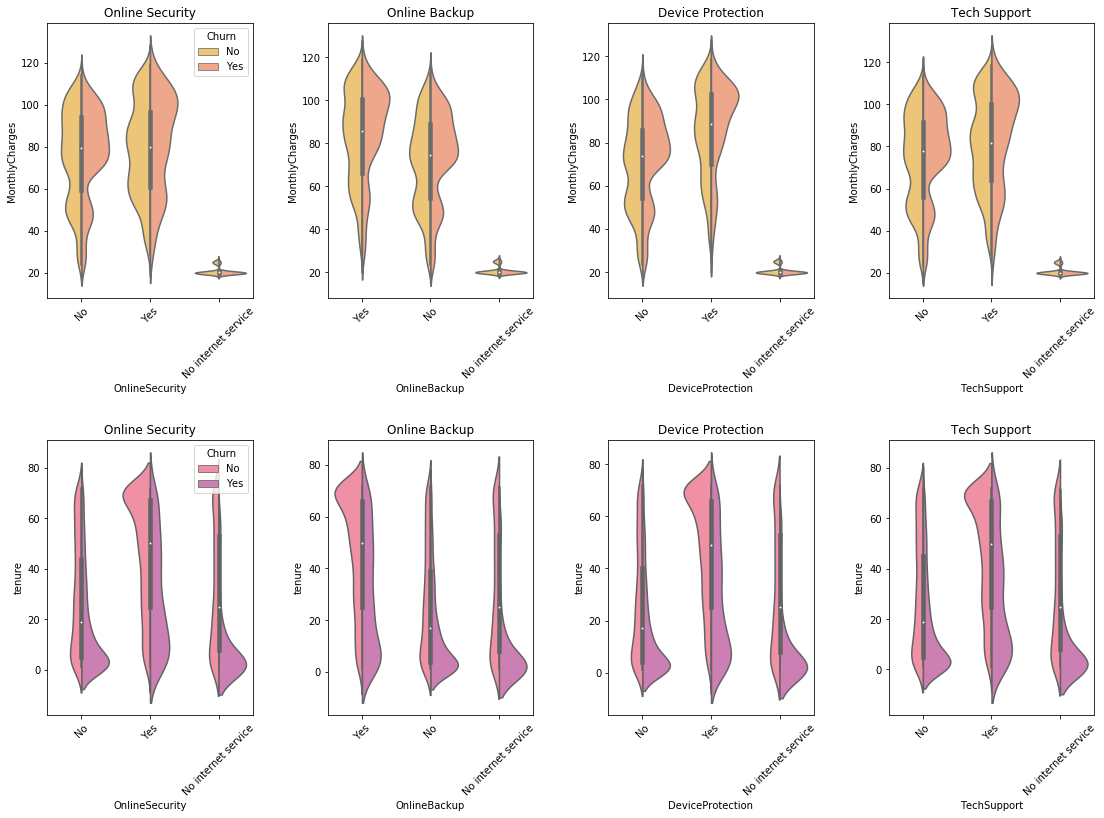

In [34]:
# OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport

fig, axis = plt.subplots(2, 4, figsize=(16,12))
axis[0][0].set_title("Online Security")
axis[0][1].set_title("Online Backup")
axis[0][2].set_title("Device Protection")
axis[0][3].set_title("Tech Support")
axis[1][0].set_title("Online Security")
axis[1][1].set_title("Online Backup")
axis[1][2].set_title("Device Protection")
axis[1][3].set_title("Tech Support")

ax = sns.violinplot(x="OnlineSecurity", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][0])
plt.setp(ax.get_xticklabels(), rotation=45)


ax = sns.violinplot(x="OnlineBackup", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()


ax = sns.violinplot(x="DeviceProtection", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="TechSupport", y="MonthlyCharges", hue="Churn",
                 split=True, palette=c_scheme, data=data, height=4.2, aspect=1.4, ax=axis[0][3])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

# tenure

ax = sns.violinplot(x="OnlineSecurity", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][0])
plt.setp(ax.get_xticklabels(), rotation=45)


ax = sns.violinplot(x="OnlineBackup", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][1])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()


ax = sns.violinplot(x="DeviceProtection", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][2])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()

ax = sns.violinplot(x="TechSupport", y="tenure", hue="Churn",
                 split=True, palette=c_scheme[2:], data=data, height=4.2, aspect=1.4, ax=axis[1][3])
plt.setp(ax.get_xticklabels(), rotation=45)
ax.legend_.remove()


plt.tight_layout(pad=3)

# Creating Categorical Features from our Continuous Variables

As we've seen throughout the exploration of our categorical variables, our continuous variables do have some impact on churn. Specifically the monthly charges and tenure options. 

Rather than normalize them between 0 and 1, I want to break them into several groups. "High, medium, and low" monthly costs, dictated by our KDE plots above. 

The bins will be as follows for monthly costs, broken up by the midpoint between the 25 and 50 IQR, and the 50 and 75 IQR.

"Low" costs from 0-53 dollars  
"Medium" costs from 54-79 dollars  
"High" costs from above 80 dollars to the max of 118 dollars/month  

Similarly, we break tenure into three categories of "low" "medium" and "high" based on the dataset's max client tenure divided into 3 categories. Thus we get:

"Low" tenure as 24 months or less  
"Medium" tenure as 25-48 months  
"High" tenure above 48 months


In [35]:
monthly_bin = []

for x in data['MonthlyCharges']:
    if x <= 53:
        monthly_bin.append('Low')
    elif  x > 80:
        monthly_bin.append('High')
    else:
        monthly_bin.append('Medium')
        

In [36]:
tenure_bin = []

for x in data['tenure']:
    if x <= 24:
        tenure_bin.append('Low')
    elif x > 48:
        tenure_bin.append('High')
    else:
        tenure_bin.append('Medium')

In [37]:
numerics = ['int64', 'float64', 'float32']
objects_df = data.select_dtypes(exclude=numerics)

objects_df['monthly_bin'] = monthly_bin
objects_df['tenure_bin'] = tenure_bin

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [38]:
objects_df.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,monthly_bin,tenure_bin
0,Female,0,Yes,No,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,No,Low,Low
1,Male,0,No,No,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,No,Medium,Medium
2,Male,0,No,No,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,Yes,Medium,Low
3,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),No,Low,Medium
4,Female,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,Yes,Medium,Low


In [39]:
data['tenure'].describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [40]:
data['MonthlyCharges'].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

## Just Categorical Plots

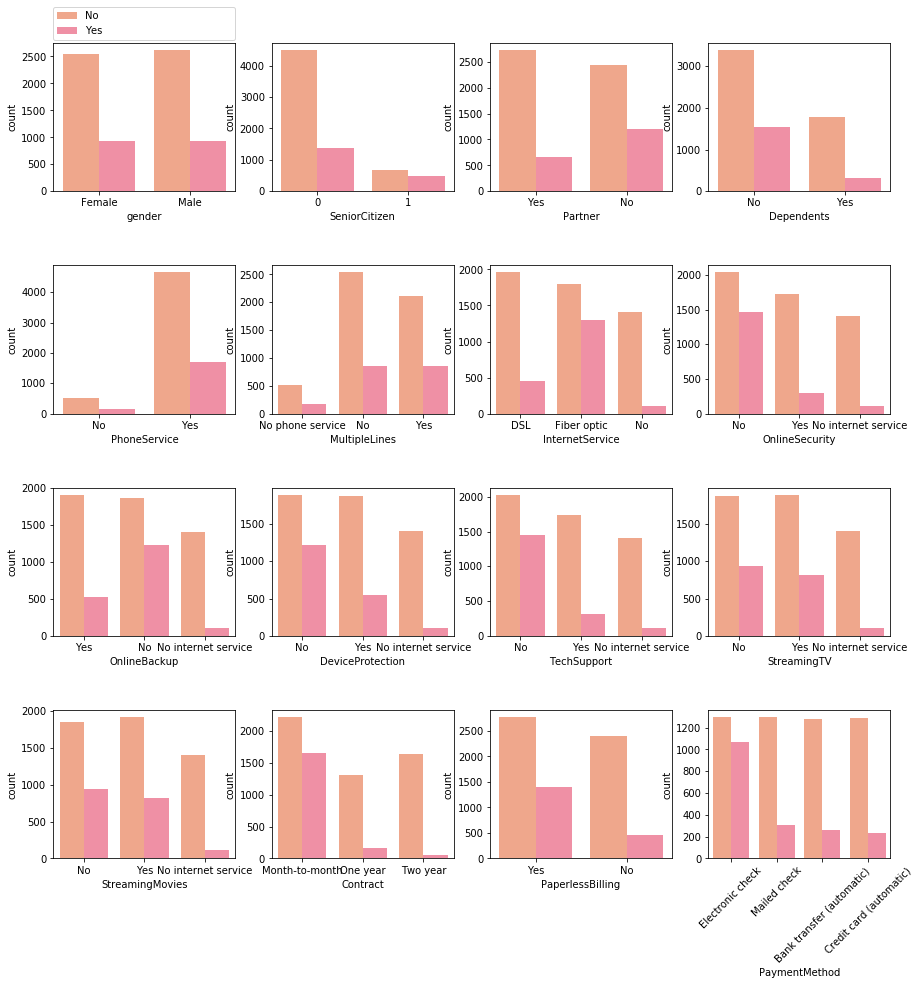

In [41]:

fig,ax =plt.subplots(4,4,figsize=(15,15))
fig.subplots_adjust(hspace=.5)
for i in range(0,16):
    g = sns.countplot(x=objects_df.iloc[:,i], hue=objects_df["Churn"], ax=ax[divmod(i,4)], palette=c_scheme[1:])
    g.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, mode="expand", borderaxespad=0.) if i==0 else g.legend_.remove()
for tick in ax[3,3].get_xticklabels():
    tick.set_rotation(45)

Text(0.5, 1.0, 'Distribution - Two Year Contract Tenure')

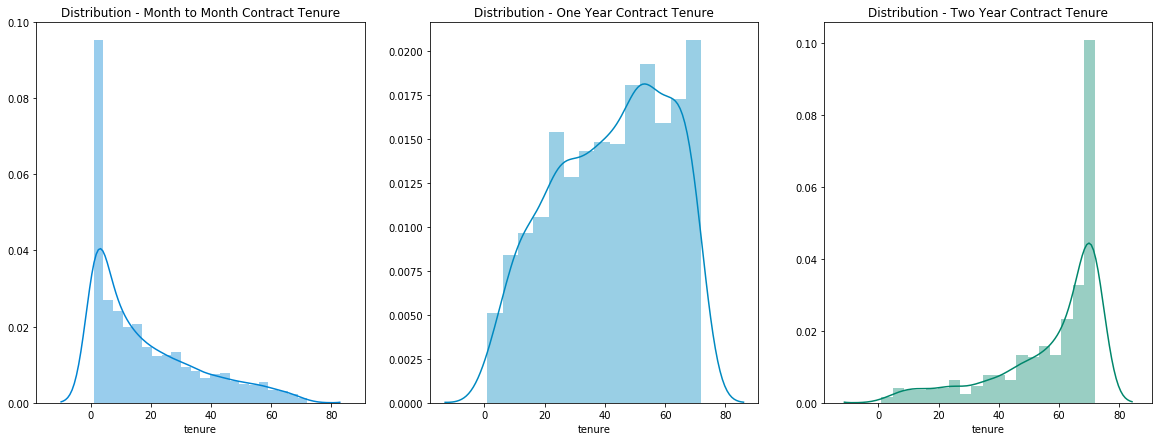

In [42]:

monthly = data.loc[lambda data: data['Contract'] == "Month-to-month", :]
one_yr = data.loc[lambda data: data['Contract'] == "One year", :]
two_yr = data.loc[lambda data: data['Contract'] == 'Two year', :]

f, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=True)


sns.distplot( monthly["tenure"] , color='#0084D3', ax=axes[0]).set_title("Distribution - Month to Month Contract Tenure")
sns.distplot( one_yr["tenure"] , color='#0089C0', ax=axes[1]).set_title("Distribution - One Year Contract Tenure")
sns.distplot( two_yr["tenure"] , color='#00866B', ax=axes[2]).set_title("Distribution - Two Year Contract Tenure")



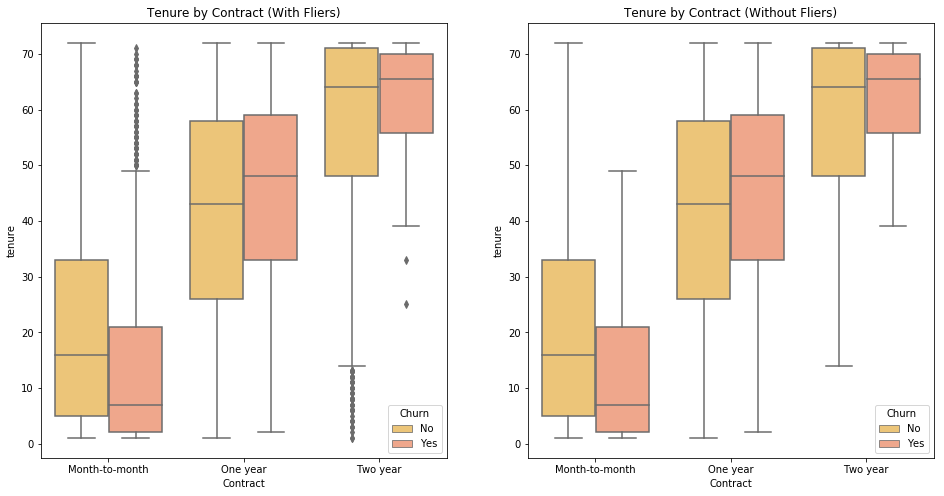

In [43]:
fig, axis = plt.subplots(1, 2, figsize=(16,8))
axis[0].set_title("Tenure by Contract (With Fliers)")
axis[1].set_title("Tenure by Contract (Without Fliers)")

ax = sns.boxplot(x="Contract", y="tenure", hue="Churn", data=data, palette=c_scheme, ax=axis[0])
ax = sns.boxplot(x="Contract", y="tenure", hue="Churn", data=data, palette=c_scheme, ax=axis[1], showfliers=False)

Text(0.5, 1.0, 'Monthly Charges - Two Year Contract')

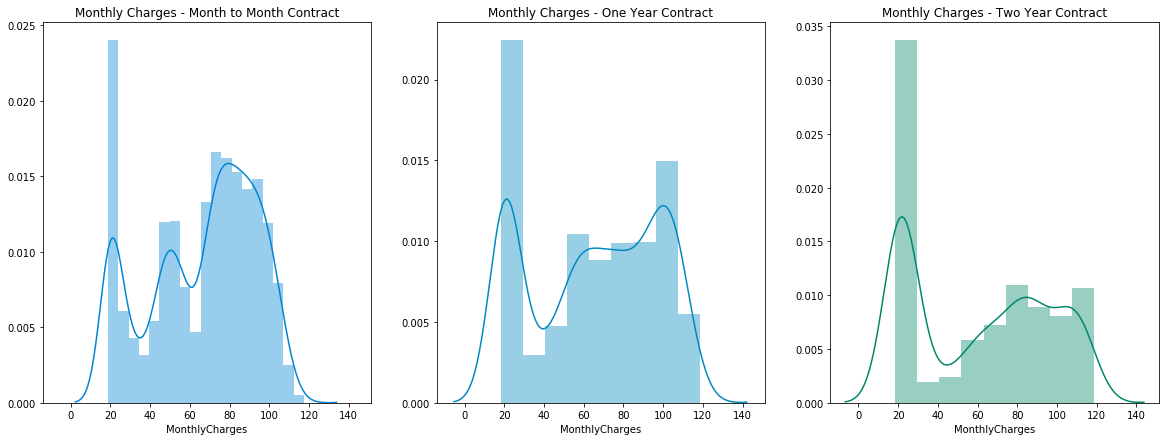

In [44]:
monthly = data.loc[lambda data: data['Contract'] == "Month-to-month", :]
one_yr = data.loc[lambda data: data['Contract'] == "One year", :]
two_yr = data.loc[lambda data: data['Contract'] == 'Two year', :]

f, axes = plt.subplots(1, 3, figsize=(20, 7), sharex=True)

sns.distplot( monthly["MonthlyCharges"] , color='#0084D3', ax=axes[0]).set_title("Monthly Charges - Month to Month Contract")
sns.distplot( one_yr["MonthlyCharges"] , color='#0089C0', ax=axes[1]).set_title("Monthly Charges - One Year Contract")
sns.distplot( two_yr["MonthlyCharges"] , color='#00866B', ax=axes[2]).set_title("Monthly Charges - Two Year Contract")


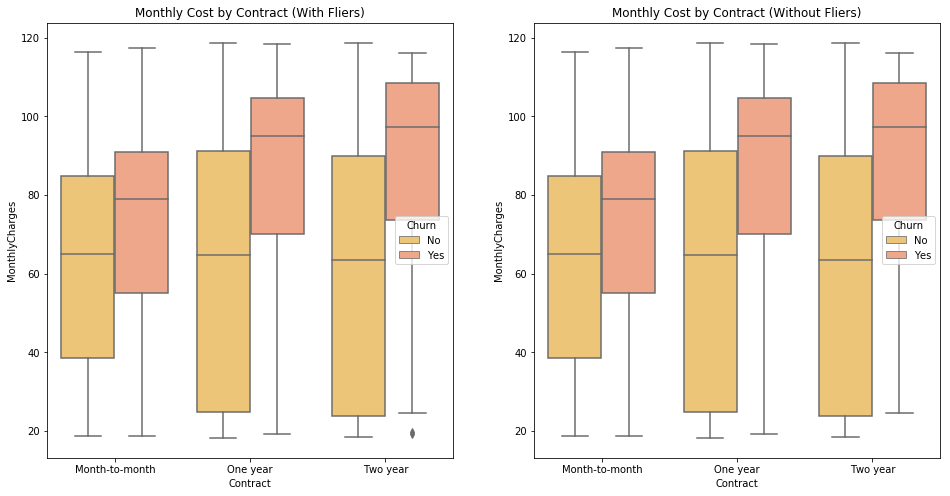

In [45]:
fig, axis = plt.subplots(1, 2, figsize=(16,8))
axis[0].set_title("Monthly Cost by Contract (With Fliers)")
axis[1].set_title("Monthly Cost by Contract (Without Fliers)")

ax = sns.boxplot(x="Contract", y="MonthlyCharges", hue="Churn", data=data, palette=c_scheme, ax=axis[0])
ax = sns.boxplot(x="Contract", y="MonthlyCharges", hue="Churn", data=data, palette=c_scheme, ax=axis[1], showfliers=False)

# Features and More Specific Exploration

In [46]:
objects_df.loc[:, "Churn_yes"] = objects_df.Churn.apply(lambda r: 1 if r == "Yes" else 0)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

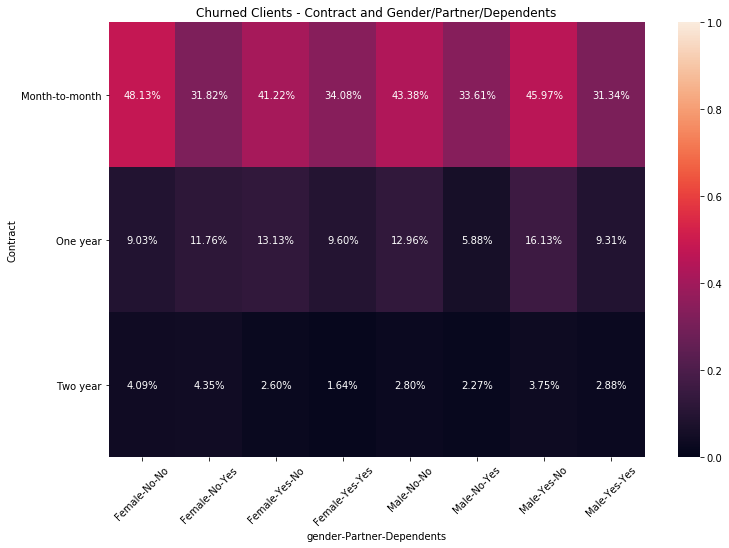

In [47]:
considerations = ['gender', 'Partner', 'Dependents']

contract = objects_df.pivot_table(values="Churn_yes" , columns=considerations, index='Contract')
plt.figure(figsize = (12,8))
#sns.set(rc={'figure.facecolor':'#757575ff'}, font_scale=1.5)
sns.heatmap(contract, annot=True, fmt="0.2%", vmin=0, vmax=1)
plt.title("Churned Clients - Contract and Gender/Partner/Dependents")
plt.yticks(rotation=0)
plt.xticks(rotation=45)

* Single females with month-to-month contracts are the highest-churn group
* Females with a partner and dependents on two year contracts are the lowest-churn group
* Within month-to-month contracts, having dependents lowers the likelihood of churn slightly
* Females with dependents but not partners are slightly higher-risk within one and two year contracts of churning, than are females with partners and no dependents, or females with partners and dependents
* Males with partners but no dependents are more likely to churn than males with dependents or males with both dependents and partners

Overall the values are close regardless of gender. 

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]),
 <a list of 8 Text xticklabel objects>)

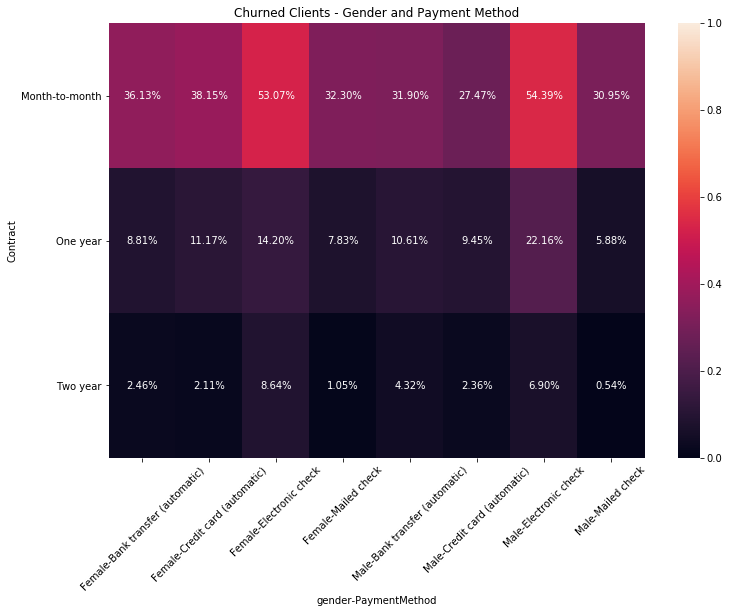

In [48]:
payment_gender = ['gender', 'PaymentMethod']

contract = objects_df.pivot_table(values="Churn_yes" , columns=payment_gender, index='Contract')
plt.figure(figsize = (12,8))
#sns.set(rc={'figure.facecolor':'#757575ff'}, font_scale=1.5)
sns.heatmap(contract, annot=True, fmt="0.2%", vmin=0, vmax=1)
plt.title("Churned Clients - Gender and Payment Method")
plt.yticks(rotation=0)
plt.xticks(rotation=45)

# Modeling

My purpose here is to find the model that can most accurately classify if a customer has churned. I want to test 8 different models:

* K-nearest neighbors Classification
* Logistic Regression (Classification L2)
* Ridge Classification
* Lasso Classification
* Decision Tree Classification
* Random Forest Classification
* C-Suppor Vector Classification (SVC)
* Gradient Boost Classification

For each model, I will go through the following steps:

* Creating a test-train split to allow me to test the models against overfitting
* Evaluation metrics. In this case, cross-validation scores on the training and test data, as well as confusion matricies
* Feature assessment and tweaking via PCA, GridSearchCV, and SelectKBest

### Section 1. Creating Holdout Groups

In [50]:
objects_df = objects_df.drop('Churn_yes', axis=1)

In [107]:
# Create dummies for object dataframes
for i in list(objects_df.columns):
    objects_df[i] = pd.Categorical(objects_df[i]) # Convert all the variables into categorical
dummy = pd.get_dummies(objects_df, drop_first=True) 

In [108]:
dummy.dtypes

gender_Male                              uint8
SeniorCitizen_1                          uint8
Partner_Yes                              uint8
Dependents_Yes                           uint8
PhoneService_Yes                         uint8
MultipleLines_No phone service           uint8
MultipleLines_Yes                        uint8
InternetService_Fiber optic              uint8
InternetService_No                       uint8
OnlineSecurity_No internet service       uint8
OnlineSecurity_Yes                       uint8
OnlineBackup_No internet service         uint8
OnlineBackup_Yes                         uint8
DeviceProtection_No internet service     uint8
DeviceProtection_Yes                     uint8
TechSupport_No internet service          uint8
TechSupport_Yes                          uint8
StreamingTV_No internet service          uint8
StreamingTV_Yes                          uint8
StreamingMovies_No internet service      uint8
StreamingMovies_Yes                      uint8
Contract_One 

In [109]:
dummy.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes,monthly_bin_Low,monthly_bin_Medium,tenure_bin_Low,tenure_bin_Medium
0,0,0,1,0,0,1,0,0,0,0,...,0,1,0,1,0,0,1,0,1,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,1
2,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,1,1,0,1,1,0
3,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
4,0,0,0,0,1,0,0,1,0,0,...,0,1,0,1,0,1,0,1,1,0


In [110]:
features = dummy.drop(["Churn_Yes"], axis=1).columns
X = dummy[features]
Y = dummy["Churn_Yes"]
validation_size = 0.30
seed = 9
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [111]:
print("normal data distribution: {}".format(Counter(Y_train)))

normal data distribution: Counter({0: 3595, 1: 1327})


In [112]:
# Trying to get more balanced data

sm = SMOTE(random_state=12, ratio=1.0)
X_train, Y_train = sm.fit_sample(X_train, Y_train)

In [113]:
# SMOTE (Synthetic Minority Over-sampling Technique) works by creating synthetic (duplicate) samples of the 
# minority class (here churners) hence making it equal to the majority class
# SMOTE does this by selecting similar records and altering them one column at a time by a random amount
# with the difference to the neighbouring records

print("SMOTE data distribution: {}".format(Counter(Y_train)))

SMOTE data distribution: Counter({0: 3595, 1: 3595})


# Model 1: KNN Classification

In [114]:
knn_model = KNeighborsClassifier()

In [115]:
# Determine the parameter values that should be searched

k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)

In [116]:
# GridSearchCV to search for the best parameters

start = time.time()
grid = GridSearchCV(knn_model, param_grid, verbose=1, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)
Y_pred_knn = grid.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  2.0min finished


Runtime 124.22


In [117]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.8200278164116829
{'n_neighbors': 8}


In [118]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(X_train, Y_train)
Y_pred_knn = knn.predict(X_train)

              precision    recall  f1-score   support

    Churn_No       0.83      0.88      0.86      3595
   Churn_Yes       0.88      0.82      0.85      3595

   micro avg       0.85      0.85      0.85      7190
   macro avg       0.85      0.85      0.85      7190
weighted avg       0.85      0.85      0.85      7190



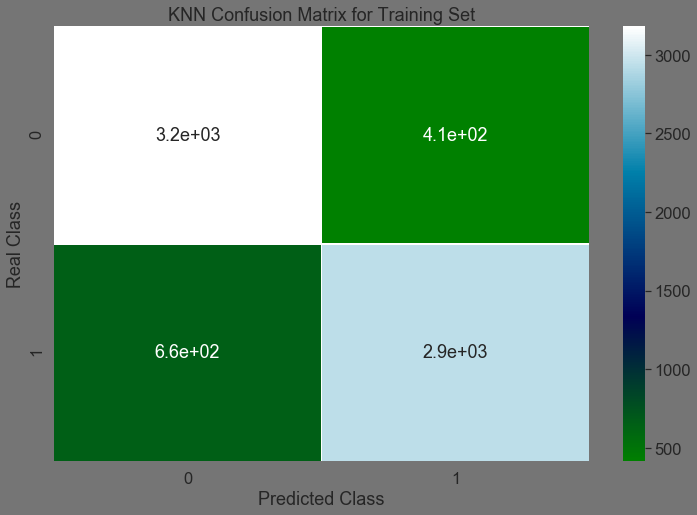

Cross Validation Accuracy Scores: 0.814(+/- 0.13)
Cross Validation Accuracy Scores - Test Set: 0.758(+/- 0.04)


In [119]:
# Print classification report
print(classification_report(Y_train, Y_pred_knn, target_names=['Churn_No', 'Churn_Yes']))

# Building confusion matrix
conf_matrix_knn = confusion_matrix(Y_train, Y_pred_knn)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.facecolor':'#757575ff', 'figure.facecolor':'#757575ff', 'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1.5)
sns.heatmap(conf_matrix_knn, 
            cmap='ocean', 
            annot=True, 
            linewidths=0.5)
plt.title('KNN Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_knn = cross_val_score(knn_model, X_train, Y_train, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_knn.mean(), scores_knn.std()*2))

scores_knnTest = cross_val_score(knn_model, X_validation, Y_validation, cv=10)
print('Cross Validation Accuracy Scores - Test Set: {:.3f}(+/- {:.2f})'.format(scores_knnTest.mean(), scores_knnTest.std()*2))

In [120]:
pred = knn.predict(X_test)

# Print classification report
print(confusion_matrix(Y_test, pred))

[[1316  252]
 [ 252  290]]


Accuracy scores for the test set, overall, are 76%, not fantastic and not terrible. However accurately predicting customers who will leave is a problem -- while we classify 83% of users who are not leaving correctly, we only have about a 50/50 chance of correctly guessing those who will stay. 

Therefore this model isn't the best.

# Logistic Regression Classification

In [132]:
logmodel = LogisticRegression()

In [122]:
# Define the parameter values that should be searched
C = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [123]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C)
print(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [133]:
# instantiate and fit the grid
grid = GridSearchCV(logmodel, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train, Y_train)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [136]:
# Logistic Regression
start = time.time()
grid.fit(X_train, Y_train)
log_reg_prediction = grid.predict(X_train)
print ("Runtime %0.2f" % (time.time() - start))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureW

Runtime 7.01


/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [139]:
# View the complete results
grid.cv_results_

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py

{'mean_fit_time': array([0.02003911, 0.05618329, 0.11152737, 0.12276659, 0.11722775,
        0.12428014, 0.12033412]),
 'std_fit_time': array([0.00322579, 0.00896339, 0.0187081 , 0.01848283, 0.01409866,
        0.01763058, 0.01336912]),
 'mean_score_time': array([0.00047002, 0.00038841, 0.00051246, 0.00051925, 0.0004153 ,
        0.00043461, 0.00049593]),
 'std_score_time': array([2.47831548e-04, 6.92557712e-05, 2.55284431e-04, 2.35161503e-04,
        1.20687497e-04, 9.38990590e-05, 1.43811172e-04]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10},
  {'C': 100},
  {'C': 1000}],
 'split0_test_score': array([0.71944444, 0.72638889, 0.72916667, 0.73333333, 0.73194444,
        0.73194444, 0.73194444]),
 'split1_test_score': array([0.71805556, 0.7       , 0.70972222, 0.7208

In [140]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.8102920723226704
{'C': 1}


In [143]:
logmodel = LogisticRegression(C=1)
logmodel.fit(X_train, Y_train)
log_reg_pred = logmodel.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [145]:
print(classification_report(Y_test,log_reg_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1568
           1       0.57      0.64      0.60       542

   micro avg       0.78      0.78      0.78      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.78      0.79      2110



In [146]:
confusion_matrix(Y_test,log_reg_pred)

array([[1304,  264],
       [ 195,  347]])